# Noise-agnostic PEC via gate extrapolation

We try to approximate each ideal gate with a _noise-agnostic_ Richardson extrapolation. For example, for 2 noise scale factors respectively equal to $1$ and $3$, an ideal gate can be appriximated as:
$$G \simeq 1.5 \, \tilde G_1^{(\lambda=1)}  - 0.5 \, \tilde G^{(\lambda=3)} $$.

More generally, for noise scale factors $\lambda \in S=\{\lambda_1, ... \lambda_m\}$, we have:
$$G \simeq  \sum_{\lambda \in S} \eta_\lambda \tilde G_1^{(\lambda)}, $$
where $\eta_\lambda$ is the quasi-probability distribution associated to Richardson extrapolation:
$$\eta_\lambda = \prod_{\lambda' \in S \setminus \{\lambda\}} \frac{\lambda'}{\lambda' - \lambda} .$$


One could scale the noise in many different ways e.g. via _pulse stretching_. Here we use _unitary folding_ which is already implemented in Mitiq.

## Note
The full execution this notebook may require a significant amount of time. If you are only interested in reproducing the figure of the paper without re-executing all the simulations, you can set `RUN_SIMULATION = False`. In this case pre-simulated results will be used and visualized.

Alternatively, another way of reducing the execution time of the full notebook (at the cost of less accurate results) is to reduce the value of `num_samples`.

In [1]:
RUN_SIMULATION = True
num_samples = 5000 # hint 5000

In [2]:
# This notebook was tested with version 0.9.3 of Mitiq.
# If necessary downgrade with the following command.
# !pip install -U mitiq==0.9.3

In [3]:
import time
from functools import partial
import numpy as np
from typing import List

rnd_state = np.random.RandomState(0)  # Set a seed

from matplotlib import pyplot as plt

import cirq
from cirq import Circuit, X, Y, Z, LineQubit, depolarize, DensityMatrixSimulator

from mitiq.pec.types import NoisyOperation
from mitiq.zne.scaling import fold_all as scale_circuit
from mitiq.benchmarks import generate_rb_circuits
from mitiq.pec.representations.depolarizing import represent_operation_with_local_depolarizing_noise
from mitiq.pec.types import OperationRepresentation
from mitiq import pec

## Utilities for NEPEC representations

We first define some functions to evaluate the quasi-probability distribution.

In [4]:
def get_richardson_coefficients(scale_factors: List[float]) -> List[float]:
    """Returns the array of Richardson extrapolation coefficients associated
    to the input array of scale factors."""
    
    # This is based on the Lagrange interpolation formula
    richardson_coeffs = []
    for l in scale_factors:
        coeff = 1.0
        for l_prime in scale_factors:
            if l_prime == l:
                continue
            coeff *= l_prime / (l_prime - l)
        richardson_coeffs.append(coeff)

    return richardson_coeffs

# Test of get_richardson_coefficients
assert np.allclose(get_richardson_coefficients([1, 3]), [1.5, -0.5])

We now define a function is usueful to easily generate NEPEC representations of arbitrary operations and with arbitrary scale factors. This is based on Richardson extrapolation of an individual gate to the zero-noise limit. 

In [5]:
def represent_operation_with_nepec(
    ideal_operation: Circuit, scale_factors: List[float]
) -> OperationRepresentation:
    """Returns the OperationRepresentation contructed by noise scaling and extrapolation."""
    
    coeffs = get_richardson_coefficients(scale_factors)
    
    basis_expansion = {}
    for scale_factor, coeff in zip(scale_factors, coeffs):
        scaled_op = NoisyOperation(scale_circuit(ideal_operation, scale_factor))
        basis_expansion[scaled_op] = coeff
    
    return OperationRepresentation(ideal_operation, basis_expansion)

# Examples
q = LineQubit(0)
print(represent_operation_with_nepec(Circuit(X(q)), scale_factors=[1, 3]))
print(represent_operation_with_nepec(Circuit(Y(q)), scale_factors=[1, 7]))
print(represent_operation_with_nepec(Circuit(Z(q)), scale_factors=[1, 3, 5]))

0: ───X─── = 1.500*0: ───X───-0.500*0: ───X───X───X───
0: ───Y─── = 1.167*0: ───Y───-0.167*0: ───Y───Y───Y───Y───Y───Y───Y───
0: ───Z─── = 1.875*0: ───Z───-1.250*0: ───Z───Z───Z───+0.375*0: ───Z───Z───Z───Z───Z───


## The error mitigation problem

Let us define a function which executes a circuit with depolarizing noise and returns an expectation value.

In [6]:
def ideal_executor(circ: Circuit) -> float:
    """Simulates a circuit without noise and returns the expectation value
    of the projector |00...><00...|.
    """
    rho = DensityMatrixSimulator().simulate(circ).final_density_matrix
    return np.real(rho[0, 0]) 

def noisy_executor(circ: Circuit, noise_level, shot_noise=0) -> float:
    """Simulates a circuit with depolarizing noise and returns the expectation value
    of the projector |00...><00...|.
    """
    noisy_circuit = circ.with_noise(depolarize(noise_level))
    return ideal_executor(noisy_circuit) + rnd_state.normal(scale=shot_noise)

Let us first define a simple RB circuit (ideally equal to the identity):

In [7]:
ideal_circuit = generate_rb_circuits(n_qubits=1, num_cliffords=5)[0]

print("Circuit under consideration: \n", ideal_circuit)
print("Circuit under consideration (operations): \n", list(ideal_circuit.all_operations()))
print("Number of gates:", len(list(ideal_circuit.all_operations())))
print("Ideal expectation value:", ideal_executor(ideal_circuit))
print("Noisy expectation value:", noisy_executor(ideal_circuit, noise_level=0.1))

Circuit under consideration: 
 0: ───Y───X^-0.5───Y───X───X───Y^0.5───X^0.5───Y^-0.5───X───Y^-0.5───Y^-0.5───X^-0.5───Y^0.5───
Circuit under consideration (operations): 
 [cirq.Y(cirq.LineQubit(0)), (cirq.X**-0.5).on(cirq.LineQubit(0)), cirq.Y(cirq.LineQubit(0)), cirq.X(cirq.LineQubit(0)), cirq.X(cirq.LineQubit(0)), (cirq.Y**0.5).on(cirq.LineQubit(0)), (cirq.X**0.5).on(cirq.LineQubit(0)), (cirq.Y**-0.5).on(cirq.LineQubit(0)), cirq.X(cirq.LineQubit(0)), (cirq.Y**-0.5).on(cirq.LineQubit(0)), (cirq.Y**-0.5).on(cirq.LineQubit(0)), (cirq.X**-0.5).on(cirq.LineQubit(0)), (cirq.Y**0.5).on(cirq.LineQubit(0))]
Number of gates: 13
Ideal expectation value: 1.0
Noisy expectation value: 0.5778122544288635


For reproducibility, we hard code one of the random circuits produced by the previous cell.

In [8]:
ideal_circuit = Circuit([(cirq.X**0.5).on(cirq.LineQubit(0)), (cirq.Y**-0.5).on(cirq.LineQubit(0)), (cirq.X**-0.5).on(cirq.LineQubit(0)), (cirq.Y**0.0).on(cirq.LineQubit(0)), (cirq.X**-0.5).on(cirq.LineQubit(0)), (cirq.Y**0.5).on(cirq.LineQubit(0)), (cirq.X**0.5).on(cirq.LineQubit(0)), (cirq.Y**0.0).on(cirq.LineQubit(0)), (cirq.Y**-0.5).on(cirq.LineQubit(0)), (cirq.X**0.5).on(cirq.LineQubit(0)), (cirq.Y**-0.5).on(cirq.LineQubit(0)), (cirq.Y**0.5).on(cirq.LineQubit(0)), (cirq.X**0.5).on(cirq.LineQubit(0)), (cirq.Y**0.5).on(cirq.LineQubit(0))])
print("Circuit under consideration: \n", ideal_circuit)
print("Circuit under consideration (operations): \n", list(ideal_circuit.all_operations()))
print("Number of gates:", len(list(ideal_circuit.all_operations())))
print("Ideal expectation value:", ideal_executor(ideal_circuit))
print("Noisy expectation value:", noisy_executor(ideal_circuit, noise_level=0.1))

Circuit under consideration: 
 0: ───X^0.5───Y^-0.5───X^-0.5───Y^0───X^-0.5───Y^0.5───X^0.5───Y^0───Y^-0.5───X^0.5───Y^-0.5───Y^0.5───X^0.5───Y^0.5───
Circuit under consideration (operations): 
 [(cirq.X**0.5).on(cirq.LineQubit(0)), (cirq.Y**-0.5).on(cirq.LineQubit(0)), (cirq.X**-0.5).on(cirq.LineQubit(0)), (cirq.Y**0.0).on(cirq.LineQubit(0)), (cirq.X**-0.5).on(cirq.LineQubit(0)), (cirq.Y**0.5).on(cirq.LineQubit(0)), (cirq.X**0.5).on(cirq.LineQubit(0)), (cirq.Y**0.0).on(cirq.LineQubit(0)), (cirq.Y**-0.5).on(cirq.LineQubit(0)), (cirq.X**0.5).on(cirq.LineQubit(0)), (cirq.Y**-0.5).on(cirq.LineQubit(0)), (cirq.Y**0.5).on(cirq.LineQubit(0)), (cirq.X**0.5).on(cirq.LineQubit(0)), (cirq.Y**0.5).on(cirq.LineQubit(0))]
Number of gates: 14
Ideal expectation value: 1.0
Noisy expectation value: 0.5674375295639038


## Define quasi-probability representations for standard PEC and noise-agnostic PEC

Set the hyperparameters of the problem.

In [9]:
# Set the assumed noise level to be used for standard PEC. This is is not used by noise-agnostic PEC.
estimated_noise = 0.01   
# Set the noise scale factors to be used for gate extrapolation.
scale_factors = [1, 51]
# The actual noise level of the device to loop over
noise_levels = [0.0, 0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015, 0.0175, 0.02]

print("Hyperparameters:")
print("num_samples:", num_samples)
print("estimated_noise:", estimated_noise)
print("scale_factors:", scale_factors)
print("noise_levels:", noise_levels)

Hyperparameters:
num_samples: 5000
estimated_noise: 0.01
scale_factors: [1, 51]
noise_levels: [0.0, 0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015, 0.0175, 0.02]


We must define an `OperationRepresentation` for each operation of the ideal circuit. The way of representing
an ideal operation is different depending on whether we use PEC or NEPEC. 

In [10]:
pec_representations = []
nepec_representations = []
for op in set(ideal_circuit.all_operations()):
    pec_rep = represent_operation_with_local_depolarizing_noise(Circuit(op), estimated_noise)
    nepec_rep = represent_operation_with_nepec(Circuit(op), scale_factors)
    pec_representations.append(pec_rep)
    nepec_representations.append(nepec_rep)

print(
    f"{len(pec_representations)} PEC representations generated assuming a"
    f" depolarizing noise level of {estimated_noise}."
)
print("Norm of the first PEC representation:", pec_representations[0].norm)
print(f"{len(nepec_representations)} NEPEC approximate representations generated"
      f" with scale factors {scale_factors} without assuming any noise model."
)
print("Norm of the first NEPEC representation:", nepec_representations[0].norm)

5 PEC representations generated assuming a depolarizing noise level of 0.01.
Norm of the first PEC representation: 1.02027027027027
5 NEPEC approximate representations generated with scale factors [1, 51] without assuming any noise model.
Norm of the first NEPEC representation: 1.04


## Run PEC and NEPEC error mitigation for different (actual) noise levels
Compared to PEC, NEPEC should be more robust to noise characterization errors. To test this fact, for each set of  gate representations, we loop over different hardware noise levels.

In [11]:
if RUN_SIMULATION:
    pre_time = time.time()
    unmitigated_values = []
    pec_values = []
    nepec_values = []
    for noise_level in noise_levels:
        executor = partial(noisy_executor, noise_level=noise_level)
        unmitigated_value = executor(ideal_circuit)
        pec_expectation_value = pec.execute_with_pec(
            ideal_circuit, executor, pec_representations, num_samples=num_samples, random_state=rnd_state,
        )
        nepec_expectation_value = pec.execute_with_pec(
            ideal_circuit, executor, nepec_representations, num_samples=num_samples, random_state=rnd_state,
        )
        # Store data
        unmitigated_values.append(unmitigated_value)
        pec_values.append(pec_expectation_value)
        nepec_values.append(nepec_expectation_value)
        print("noise_level:", noise_level)

    print(f"Execution time: {round(time.time() - pre_time)} seconds")
    print("unmitigated_values:")
    print(unmitigated_values)
    print("pec_values:")
    print(pec_values)
    print("nepec_values:")
    print(nepec_values)

noise_level: 0.0
noise_level: 0.0025
noise_level: 0.005
noise_level: 0.0075
noise_level: 0.01
noise_level: 0.0125
noise_level: 0.015
noise_level: 0.0175
noise_level: 0.02
Execution time: 1563 seconds
unmitigated_values:
[1.0, 0.9771649837493896, 0.9553019404411316, 0.9343726634979248, 0.9143394827842712, 0.8951672911643982, 0.8768202662467957, 0.8592677116394043, 0.8424772024154663]
pec_values:
[1.1037399004925463, 1.0710962557251942, 1.0441431804011696, 1.0171574927661557, 0.9900251727790881, 0.9821376730077583, 0.9734147430444995, 0.9325036642754185, 0.9179650973609916]
nepec_values:
[1.0022943278725032, 0.9914572396688774, 0.9800362219341194, 0.9740868290281771, 0.9961705000775363, 0.9785262910414021, 0.9367166210811602, 0.9430686185923336, 0.8967033957276255]


# Visualize data

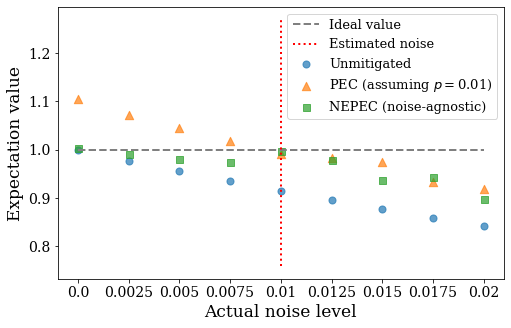

In [12]:
def plot_results(save_to_pdf: bool):
    
    plt.rcParams.update({"font.family": "serif", "font.size": 13})

    plt.figure(figsize=(8, 5))

    # Limits for the dotted line
    max_y = 1.15 * max(unmitigated_values + pec_values + nepec_values)
    min_y = 0.9 * min(unmitigated_values + pec_values + nepec_values)

    markersize = 50
    alpha = 0.7
    axis_title_size = 17

    plt.hlines(1, noise_levels[0], noise_levels[-1], label="Ideal value",  linewidth=2, color="gray", linestyle="dashed")
    plt.vlines(estimated_noise, min_y, max_y, colors="red", linewidth=2, linestyles="dotted", label="Estimated noise")

    plt.scatter(noise_levels, unmitigated_values, label="Unmitigated", s=markersize, alpha=alpha)
    plt.scatter(noise_levels, pec_values, label=f"PEC (assuming $p=${estimated_noise})", s=markersize * 1.4, alpha=alpha, marker="^")
    plt.scatter(noise_levels, nepec_values, label="NEPEC (noise-agnostic)", s=markersize* 0.98, alpha=alpha, marker="s")
    plt.xlabel("Actual noise level", size=axis_title_size)
    plt.ylabel("Expectation value", size=axis_title_size)
    tick_label_size=14
    
    noise_levels_strings = [str(x) for x in noise_levels]
    plt.xticks(noise_levels, noise_levels_strings, size=tick_label_size)
    plt.yticks(size=tick_label_size)
    plt.legend()
    if save_to_pdf:
        plt.savefig("noise_agnostic_pec.pdf")
    plt.show()

if RUN_SIMULATION:
    plot_results(save_to_pdf=False)

# Exactly reproduce the figure of the paper
When running the original simulation that is reported in the figure of the paper, unfortunately the seed rnd_state was not used. This means that the plot above may be similar but not exactly equal to the plot of the paper.

If one is interested in exactly reproducing the figure of the paper, one can manually set the results of the original simulation executing the next cell.

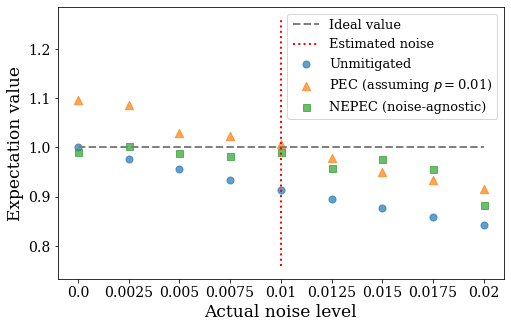

In [13]:
# Copied and pasted from the results of the original simulation
estimated_noise = 0.01
noise_levels = [0.0, 0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015, 0.0175, 0.02]

unmitigated_values = [1.0, 0.9771649837493896, 0.9553019404411316, 0.9343726634979248, 0.9143394827842712, 0.8951672911643982, 0.8768202662467957, 0.8592677116394043, 0.8424772024154663]
pec_values = [1.0960584852983337, 1.0853695043192624, 1.0303496725029109, 1.0233014296449234, 1.007734938518927, 0.978401611707598, 0.9496199737039019, 0.9333176714050502, 0.9162332037002223]
nepec_values = [0.9912115986078454, 1.0033896985521815, 0.9889737214304639, 0.9819374507223545, 0.9901931989592324, 0.9585728679844749, 0.9763846412773582, 0.9556384601575977, 0.8822034714765001]

plot_results(save_to_pdf=False)

In [14]:
import mitiq

mitiq.about()


Mitiq: A Python toolkit for implementing error mitigation on quantum computers
Authored by: Mitiq team, 2020 & later (https://github.com/unitaryfund/mitiq)

Mitiq Version:	0.10.0dev

Core Dependencies
-----------------
Cirq Version:	0.10.0
NumPy Version:	1.20.1
SciPy Version:	1.4.1

Optional Dependencies
---------------------
PyQuil Version:	2.28.0
Qiskit Version:	0.24.0
Braket Version:	1.5.16

Python Version:	3.7.7
Platform Info:	Linux (x86_64)
